In [1]:
library(tidyverse)
library(cowplot)
library(arrow)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

# 1. Gather and process data

In [2]:
direct_time_df = tribble(
    ~method, ~n_phenotypes, ~time,
    "Plink 2"             ,          1,       978 ,
    "Plink 2"             ,          5,      1222 ,
    "Plink 2"             ,         10,      1498 ,
    "Regenie step 1"      ,          1,    10464 ,
    "Regenie step 1"      ,          5,    11815 ,
    "Regenie step 1"      ,         10,    17573 ,
    "Regenie step 2"      ,          1,     9327 ,
    "Regenie step 2"      ,          5,    10268 ,
    "Regenie step 2"      ,         10,    11219 ,
    "FastGWA GRM 15/15"   ,          NULL,     6075 ,
    "FastGWA GRM sparsify", NULL, 1146,
    "FastGWA GWAS"        ,          1,           3996,
    "FastGWA GWAS"        ,          5,           19982,
    "FastGWA GWAS"        ,         10,           39965,
)

igwas_time_df <- tribble(
    ~input, ~output, ~time,
    100, 1000, 2916,
    10, 100, 261,
    125, 500, 1473,
    250, 1000, 3510,
    250, 500, 1763,
    25, 100, 274,
    375, 500, 1963,
    500, 1000, 4288,
    50, 100, 306,
    50, 500, 1356,
    750, 1000, 4961,
    75, 100, 331,
)

In [3]:
combined_times_df <- bind_rows(
    direct_time_df %>% 
        filter(method == "Plink 2"),
    direct_time_df %>%
        filter(method %>% str_detect("Regenie")) %>%
        pivot_wider(names_from = method, values_from = time) %>%
        mutate(
            time = `Regenie step 1` + `Regenie step 2`,
            method = "Regenie"
        ) %>%
        select(method, n_phenotypes, time),
    direct_time_df %>%
        filter(method %>% str_detect("FastGWA")) %>%
        pivot_wider(names_from = method, values_from = time) %>%
        fill(-n_phenotypes, .direction = "updown") %>%
        drop_na %>%
        mutate(
            time = `FastGWA GRM 15/15` + `FastGWA GRM sparsify` + `FastGWA GWAS`,
            method = "FastGWA"
        ) %>%
        select(method, n_phenotypes, time)
) %>%
    mutate(n_phenotypes = as.double(n_phenotypes))

# 2. Extrapolate to larger dimensions

In [4]:
n_phenotype_target <- c(30, 1866, 13000, 68000)
fraction_target <- c(10, 25, 50, 75, 100)

target_df <- expand_grid(n_phenotype_target, fraction_target) %>%
    mutate(n_phenotypes = n_phenotype_target * fraction_target / 100)

## 2.1. Fit a model to predict indirect GWAS runtimes

Function of input and output dimensions. For our purposes, it's most helpful to think in terms of number of phenotypes and compression fraction.

In [5]:
runtime_model <- igwas_time_df %>%
    mutate(fraction = 100 * input / output) %>%
    rename(fraction_target = fraction, n_phenotypes = output) %>%
    lm(time ~ fraction_target * n_phenotypes + poly(n_phenotypes, 2), data = .)

broom::glance(runtime_model)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.9981869,0.9971508,87.41261,963.4494,1.140442e-09,4,-67.44096,146.8819,149.7914,53486.75,7,12


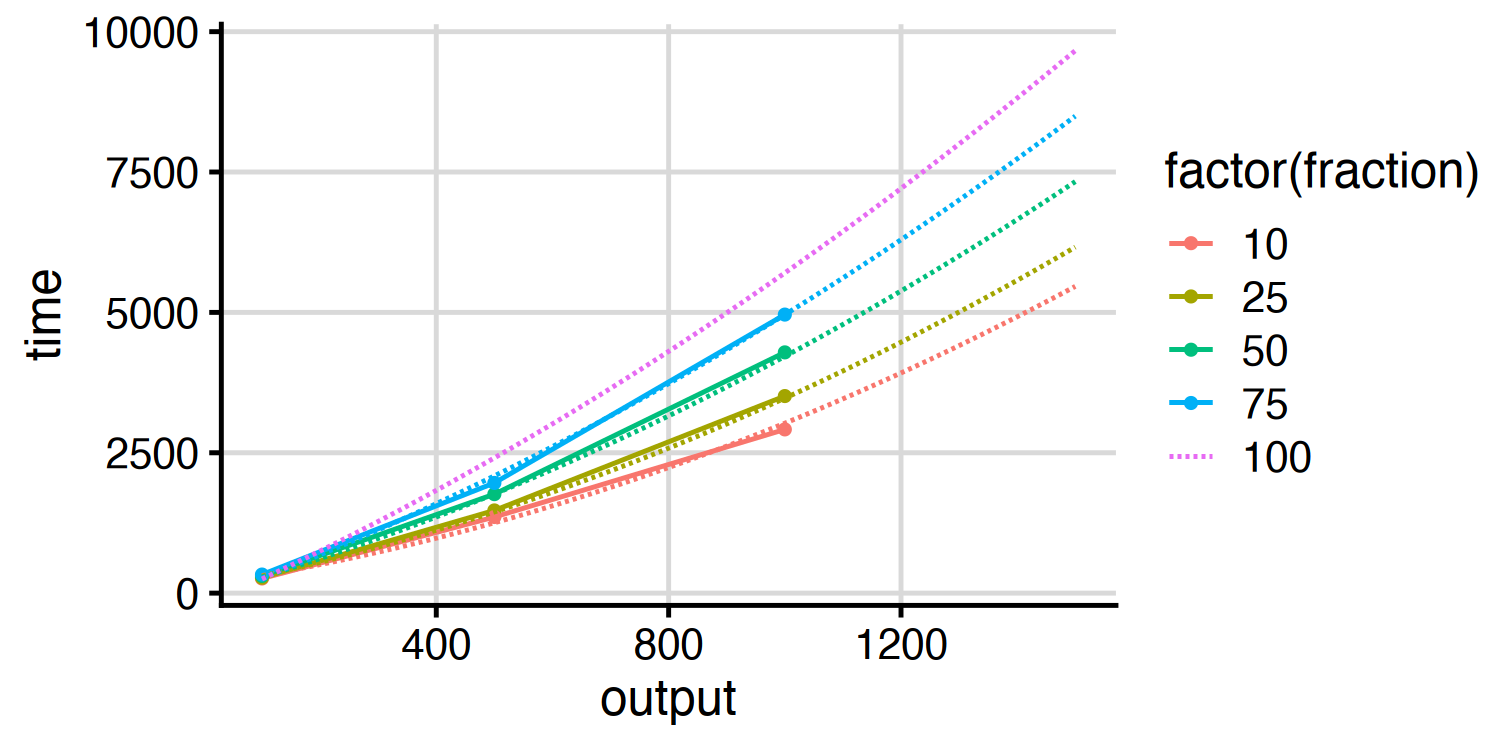

In [6]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 250)

igwas_time_df %>%
    mutate(fraction = 100 * input / output) %>%
    ggplot(aes(x = output, y = time, group = factor(fraction), color = factor(fraction))) +
    geom_line() +
    geom_point(size = 1) +
    geom_line(
        data = broom::augment(runtime_model, newdata = expand_grid(n_phenotypes = seq(100, 1500), fraction_target)),
        aes(x = n_phenotypes, y = .fitted, group = factor(fraction_target), color = factor(fraction_target)),
        linetype = "dashed"
    ) +
    theme_cowplot() +
    background_grid()

In [7]:
extrapolated_df <- combined_times_df %>%
    nest(data = -method) %>%
    rowwise() %>%
    mutate(
        l = data %>%
            lm(time ~ n_phenotypes, data = .) %>%
            broom::augment(newdata = target_df) %>%
            list
    ) %>%
    ungroup %>%
    select(-data) %>%
    unnest(l) %>%
    rename(direct_time = .fitted) %>%
    broom::augment(runtime_model, newdata = .) %>%
    rename(indirect_time = .fitted) %>%
    mutate(
        time = direct_time + indirect_time,
        direct_method = if_else(
            fraction_target == 100,
            "Direct",
            str_glue("Indirect ({fraction_target}%)")
        ) %>% fct_reorder(fraction_target) %>% fct_rev,
        label = n_phenotype_target %>%
            recode_factor(
                `30` = "UKBB blood biochemistry (N=30)",
                `1866` = "Phecodes (N=1,866)",
                `13000` = "ICD-9-CM (N=13,000)",
                `68000` = "ICD-10-CM (N=68,000)"
            ),
        method = factor(method, levels = c("Plink 2", "FastGWA", "Regenie"))
    )

extrapolated_df %>% write_tsv("plot_data/extrapolated_timing.tsv")

extrapolated_df %>% head(2)

method,n_phenotype_target,fraction_target,n_phenotypes,direct_time,indirect_time,time,direct_method,label
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
Plink 2,30,10,3.0,1098.098,149.6822,1247.781,Indirect (10%),UKBB blood biochemistry (N=30)
Plink 2,30,25,7.5,1357.623,99.5243,1457.147,Indirect (25%),UKBB blood biochemistry (N=30)


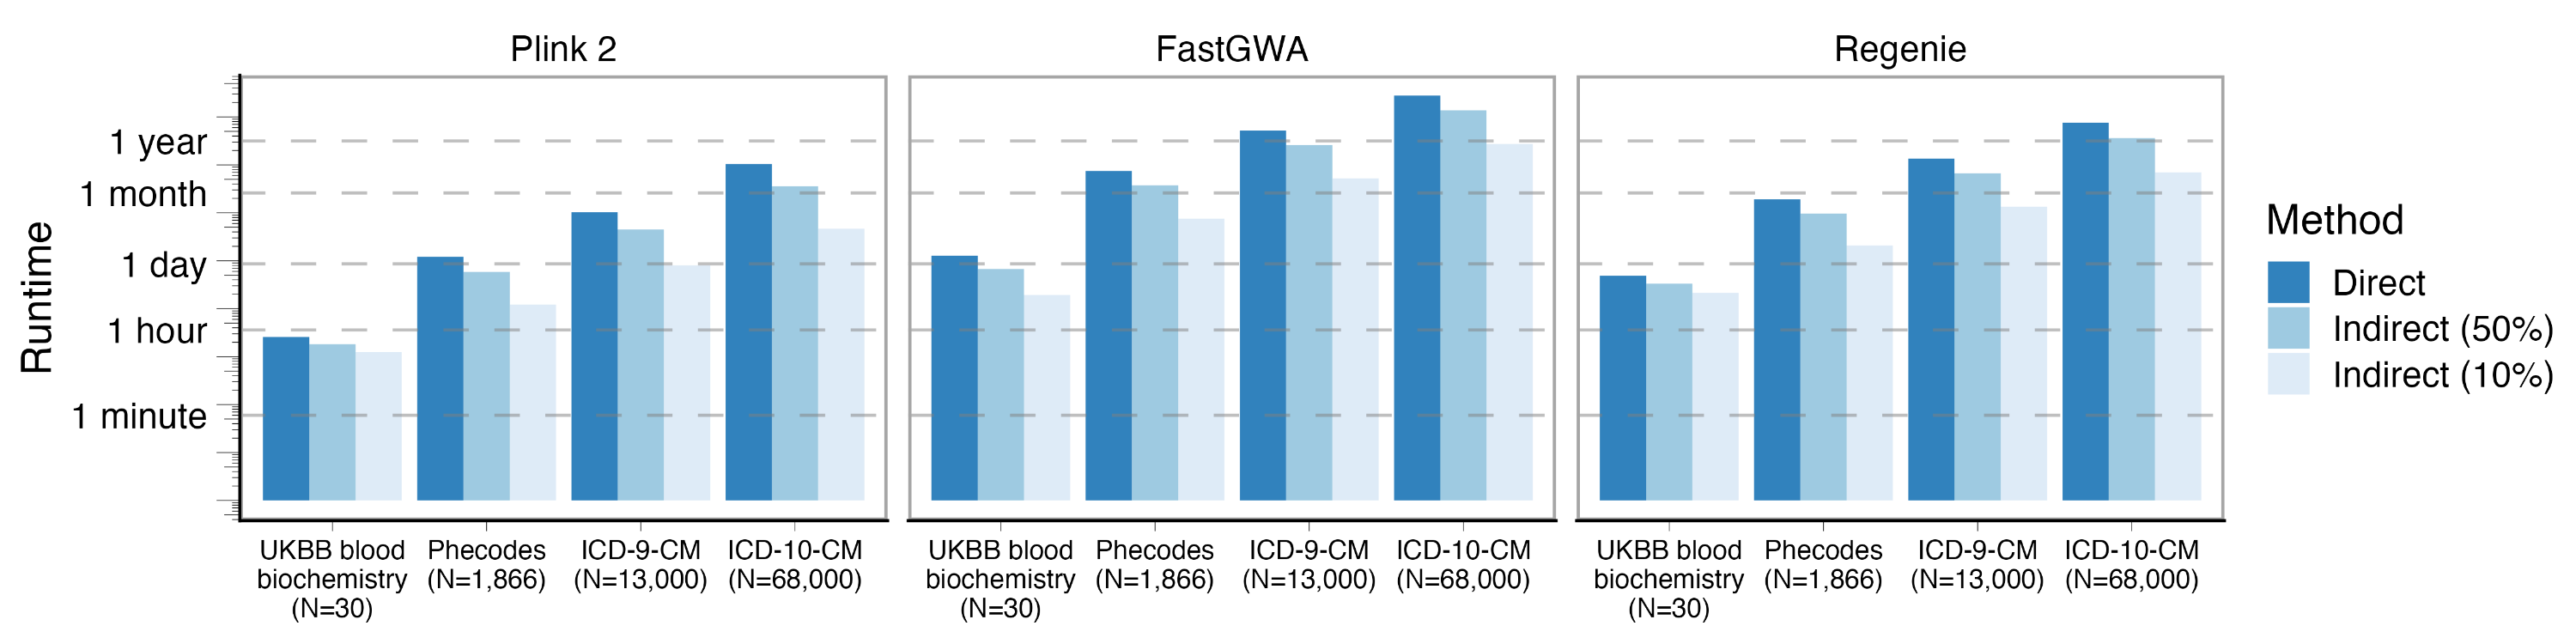

In [8]:
options(repr.plot.width = 12, repr.plot.height = 3, repr.plot.res = 250)

hlines <- c(
    "1 minute" = 60,
    "1 hour" = 60 * 60, 
    "1 day" = 60 * 60 * 24, 
    # "1 week" = 60 * 60 * 24 * 7, 
    "1 month" = 60 * 60 * 24 * 30,
    "1 year" = 60 * 60 * 24 * 365
) %>% as_tibble(rownames = "unit")

timing_plot <- extrapolated_df %>%
    filter(fraction_target %in% c(10, 50, 100)) %>%
    ggplot(aes(x = label, y = time, fill = direct_method, group = direct_method)) +
    geom_col(position = position_dodge()) +
    geom_hline(data = hlines, aes(yintercept = value), linetype = "88", color = "grey50", alpha = 0.5) +
    facet_wrap(vars(method)) +
    theme_cowplot() +
    panel_border(color = "grey65") +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_text(size = 9),
        axis.text.y = element_text(size = 12),
        axis.ticks = element_line(colour = "black", linewidth = 0.1),
        strip.background = element_rect(fill = NA)
    ) +
    scale_fill_brewer(palette = "Blues", direction = -1, name = "Method") +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 10)) +
    scale_y_log10(
        breaks = hlines$value, labels = hlines$unit,
        guide = guide_axis_logticks()
    ) +
    ylab("Runtime")

save_plot("img/gwas_timing.png", timing_plot, base_width = 12, base_height = 3, dpi = 400)

grid::grid.raster(png::readPNG("img/gwas_timing.png"))   